In [3]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.init as init
import time
from torch.optim.lr_scheduler import StepLR

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.init as init
import time
from torch.optim.lr_scheduler import StepLR

# PINN architecture for 2D problem
import torch
import torch.nn as nn

# class PINN2D(nn.Module):
#     def __init__(self, n_particle, n_dimension, num_hidden_layers=3, num_neurons_per_layer=64, bound=2*torch.pi):
#         super().__init__()
        
#         # Input layer: new input is 2ND+1 after transformation
#         self.input_layer = nn.Linear(2*n_particle*n_dimension+1, num_neurons_per_layer)

#         # Hidden layers
#         self.hidden_layers = nn.ModuleList([
#             nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
#             for _ in range(num_hidden_layers)
#         ])
        
#         # Output layer: output ND dimensions
#         self.output_layer = nn.Linear(num_neurons_per_layer, n_particle*n_dimension)

#         # Activation function
#         self.activation = nn.Tanh()
#         self.bound = bound
        
#         # Initialize weights using Xavier initialization
#         for layer in self.hidden_layers:
#             nn.init.xavier_normal_(layer.weight.data)
#             nn.init.zeros_(layer.bias.data)

#     def forward(self, t, samples_prior):
#         # Step 1: Transform samples_prior(high dimension) using sin/cos by setting every coordinates to its sin/cos 
#         inputs = torch.cat([torch.cos(samples_prior*2*torch.pi/self.bound), torch.sin(samples_prior*2*torch.pi/self.bound),t], dim=1)

#         # Step 3: Pass through network
#         outputs = self.activation(self.input_layer(inputs))
#         for layer in self.hidden_layers:
#             outputs = self.activation(layer(outputs)) + outputs  
 
#         # Step 4: Pass through output layer (4D output)
#         outputs = self.output_layer(outputs)  

#         # Step 6: Stack to return 2D output
#         return outputs - self.bound * torch.round(outputs / self.bound)
    


class TorusEGNN (nn.Module):
    def __init__(self, feat_dim: int, edge_dim:int = 0, hidden_dim:int = 128, dropout:float = 0.1):
        super().__init__()

        edge_input_dim = feat_dim * 2 + 1 + edge_dim +1 # feat_i + feat_j + rel_dist + edge + time    

        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_input_dim, hidden_dim // 2),
            nn.Dropout(dropout),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.Dropout(dropout),
            nn.SiLU(),
        )

        self.edge_gate = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        # self.node_norm = nn.LayerNorm(feat_dim) if norm_feats else nn.Identity()
        # self.coors_norm = CoorsNorm(scale_init = norm_coors_scale_init) if norm_coors else nn.Identity()

        self.node_mlp = nn.Sequential(
            nn.Linear(feat_dim + hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Dropout(dropout),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, feat_dim),
        )

        self.coors_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Dropout(dropout),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

        self.apply(self.init_)

    def init_(self, module):
        if type(module) in {nn.Linear}:
            # seems to be needed to keep the network from exploding to NaN with greater depths
            nn.init.xavier_normal_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, feats, coors, t, edges = None, mask = None):
        b, n, d, device = *feats.shape, feats.device

        if mask is not None:
            num_nodes = mask.sum(dim = -1)

        # rel_coors = rearrange(coors, 'b i d -> b i () d') - rearrange(coors, 'b j d -> b () j d')
        rel_coors = coors[:,:,None,:] - coors[:,None,:,:]                                   # b i 1 d - b 1 j d = b i j d
        rel_coors = rel_coors - 2 * math.pi * torch.round(rel_coors / (2 * math.pi))        # wrap at boundary
        rel_dist = (rel_coors ** 2).sum(dim = -1, keepdim = True)

        i = j = n

        feats_j, feats_i = feats[:,None,:,:], feats[:,:,None,:]
        feats_i, feats_j = torch.broadcast_tensors(feats_i, feats_j)

        t = t.view(b,1,1,1).expand(b,n,n,1)

        edge_input = torch.cat((feats_i, feats_j, rel_dist, t), dim = -1) # combine the time with distance input

        if edges is not None:
            edge_input = torch.cat((edge_input, edges), dim = -1)

        # message of edges
        m_ij = self.edge_mlp(edge_input)
        m_ij = m_ij * self.edge_gate(m_ij)                          # b i j h

        # message of coordinates
        coor_weights = self.coors_mlp(m_ij)
        coor_weights = torch.squeeze(coor_weights, dim=-1)          # b i j

        # rel_coors = self.coors_norm(rel_coors)

        if mask is not None:
            coor_weights.masked_fill_(~mask, 0.)

        # aggregation and update of coordinates
        coors_out = torch.einsum('b i j, b i j c -> b i c', coor_weights, rel_coors / (rel_dist + 2 * torch.math.pi)) + coors

        # if mask is not None:
        #     # m_ij_mask = rearrange(mask, '... -> ... ()')
        #     m_ij_mask = mask[..., None]
        #     m_ij = m_ij.masked_fill(~m_ij_mask, 0.)

        # # aggregation of edges
        # m_i = m_ij.sum(dim = -2)
        
        # update of nodes
        # normed_feats = self.node_norm(feats)
        # node_mlp_input = torch.cat((feats, m_i), dim = -1)
        # node_out = self.node_mlp(node_mlp_input) + feats

        return coors_out
    

class PINN2D (nn.Module):
    def __init__(self, num_node: int, coor_dim: int, feat_dim: int, edge_dim: int=0, hidden_dim: int=128, num_layers: int=2, dropout: float=0.1):
        super().__init__()

        # mask out self connection
        self.register_buffer('mask', (1 - torch.eye(num_node))[None, ...])
        self.layers = nn.Sequential(
            *[TorusEGNN(feat_dim=feat_dim, edge_dim=edge_dim, hidden_dim=hidden_dim, dropout=dropout) for _ in range(num_layers)]
        )
        self.output_fc = nn.Linear(feat_dim+coor_dim, coor_dim)
                         
        nn.init.xavier_normal_(self.output_fc.weight)
        nn.init.zeros_(self.output_fc.weight)

    def forward(self, feats, coors, t, edges = None):
        b, n, device = feats.shape[0], feats.shape[1], feats.device

        # coors_residual = coors   
        # go through layers
        # coor_changes = [coors]

        for egnn in self.layers:
            coors = egnn(feats, coors, edges = edges, t, mask = self.mask)
            # coor_changes.append(coors)

        # if return_coor_changes:
        #     return feats, coors, coor_changes

        t  = t.view(b,1,1).expand(b,n,1)

        coors = self.output_fc(torch.cat((feats, coors, t), dim=-1))
        # coors -= coors_residual
        return coors.flatten(start_dim=1)


class Time_residual(nn.Module):
    def __init__(self, num_hidden_layers=2, num_neurons_per_layer=64):
        super().__init__()
        
        # Input layer: 1D input (time)
        self.input_layer = nn.Linear(1, num_neurons_per_layer)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output layer: 1D output (time residual)
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        # Activation function
        self.activation = nn.Tanh()
        
        # Initialize weights using Xavier initialization
        nn.init.xavier_normal_(self.input_layer.weight.data)
        nn.init.zeros_(self.input_layer.bias.data)
        
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)
            
        nn.init.xavier_normal_(self.output_layer.weight.data)
        nn.init.zeros_(self.output_layer.bias.data)

    def forward(self, t):
        """
        Forward pass through the network.
        
        Args:
            t (torch.Tensor): Time input of shape [batch_size, 1]
            
        Returns:
            torch.Tensor: Time residual output c_t of shape [batch_size, 1]
        """
        # Pass through network with residual connections
        outputs = self.activation(self.input_layer(t))
        
        for layer in self.hidden_layers:
            layer_output = self.activation(layer(outputs))
            outputs = layer_output + outputs  # Residual connection
        
        # Final output layer
        c_t = self.output_layer(outputs)
        
        return c_t
    
def lennard_jones_energy_full(x, n_particles, n_dims, box_length=2*torch.pi, eps=1.0, rm=1.0, r_switch=0.95, r_cutoff=2.5, remove_diagonal=True):
    """
    Compute Lennard-Jones energy using linear approximation for r < r_cut.
    Args:
        x: Tensor of shape (B, N * D), flattened particle coordinates
        n_particles: Number of particles N
        n_dims: Number of spatial dimensions D
        box_length: Periodic box size
        eps, rm: LJ parameters
        r_cut: linear cutoff distance
        remove_diagonal: whether to exclude self-interactions
        
    Returns:
        lj_energy: Tensor of shape (B, 1)
    """

    # 1. Reshape x to (B, N, D)
    x = x.view(-1, n_particles, n_dims)

    # 2. Apply PBC to compute pairwise displacements: shape (B, N, N, D)
    delta = x.unsqueeze(2) - x.unsqueeze(1)  # [B, N, N, D]
    delta = delta - box_length * torch.round(delta / box_length)

    # 3. Optionally remove diagonal entries
    if remove_diagonal:
        B, N, _, D = delta.shape
        mask = ~torch.eye(N, dtype=torch.bool, device=x.device)  # [N, N]
        mask = mask.unsqueeze(0).expand(B, N, N)                 # [B, N, N]
        delta = delta[mask].view(B, N, N - 1, D)

    # 4. Compute distances r = ||delta||: shape (B, N, N-1)
    r = delta.pow(2).sum(dim=-1).sqrt()  # [B, N, N-1]

    # 5. Compute linear approximation: V = a * r + b where r < r_cut
    a = -5.0
    lj_at_cut = 4.0 * eps * ((rm / r_switch)**12 - (rm / r_switch)**6)
    b = lj_at_cut - a * r_switch
    V = a * r + b

    # 6. Apply full LJ where r >= r_cut
    mask = (r >= r_switch)
    if mask.any():
        r_big = r[mask]
        V[mask] = 4.0 * eps * ((rm / r_big)**12 - (rm / r_big)**6)
    
    V[r > r_cutoff] = 0.0

    # 7. Sum over all pairwise terms, divide by 2 to avoid double counting
    lj_energy = V.sum(dim=(-2, -1)) / 2  # shape (B,)
    
    return lj_energy[:, None]  # shape (B, 1)

def vector_distance(samples,Velocity,f_t):
    # Samples is a tensor of shape (B, N*D）
    # Velocity_field is a tensor of shape (B, N*D)
    # Internal_energy_ is a tensor of shape (B,1)
    # Expected result is a tensor of shape (B,1)
    
    gradient = torch.autograd.grad(f_t, samples, grad_outputs=torch.ones_like(f_t), create_graph=True)[0]
    # Detect when gradient exists Nan, output samples and inter_energy

    if torch.isnan(gradient).any():
        nan_mask = torch.isnan(gradient).any(dim=1)
        print("NaN detected in gradient!")
        print("Problematic samples:\n", samples[nan_mask])
        print("Corresponding internal energy:\n", f_t[nan_mask])
        raise ValueError("NaN detected in gradient computation.")

    # Compute the distance
    result = torch.sum(gradient * Velocity,dim = 1)
    
    assert not torch.isnan(result).any(), "Result is NaN"
    result = result.unsqueeze(dim = 1)
    return result

def compute_divergence(Velocity, t, x):
    """
    model: the neural network representing the vector field
    t: torch tensor of shape [B, 1]
    x: torch tensor of shape [B, D]
    """
    x.requires_grad_(True)
    v = Velocity(t, x)  # [B, D]
    
    divergence = torch.zeros(x.shape[0], device=x.device)
    for i in range(v.shape[1]):
        grad_v_i = torch.autograd.grad(
            outputs=v[:, i],
            inputs=x,
            grad_outputs=torch.ones_like(v[:, i]),
            create_graph=True,
            retain_graph=True
        )[0][:, i]  # 只取 ∂v_i/∂x_i
        divergence += grad_v_i

    return divergence.view(-1,1)  # shape [B]

# PDE residual formula for 2D diffusion equation
def pde_formula(x, t_value, Velocity_model, Normalizing_model, n_particles, n_dimension):
    '''
    t_value: torch tensor of shape [B, 1]
    x: torch tensor of shape [B, N*D]
    '''
    # First term is energy
    U = lennard_jones_energy_full(x, n_particles, n_dimension)
    f_t = t_value * U
    # check if U is NaN
    assert torch.isnan(f_t).sum() == 0, "Energy is NaN"

    velocity_field = Velocity_model(t_value, x)
    assert torch.isnan(velocity_field).sum() == 0, "Velocity field is NaN"
    
    term2 = vector_distance(x, velocity_field, f_t)
    assert torch.isnan(term2).sum() == 0, "Term2 is NaN"
        
    trace_average = compute_divergence(Velocity_model, t_value, x)
    assert torch.isnan(trace_average).sum() == 0, "Trace average is NaN"

    C_t = Normalizing_model(t_value)
    assert torch.isnan(C_t).sum() == 0, "C_t is NaN"

    return torch.abs(U + term2 - trace_average +C_t) #+ (U + term2 - trace_average +C_t)**2


# Loss function for 2D PINN with time range [0.1, 1] and vector output correction
def compute_loss(Velocity, Time_residual, n_particles, n_dimension, device="cuda", bound = 2*torch.pi):
    # Sample collocation points for PDE residual
    n_pde_points = 10000  # Number of points inside domain
    samples = torch.rand(n_pde_points, n_particles*n_dimension, device=device,requires_grad=True) * bound - bound/2  # Range [-10, 10]
    t_value = 1.0 - torch.rand(n_pde_points, 1, device=device)
    pde_loss_t = pde_formula(samples, t_value, Velocity, Time_residual, n_particles, n_dimension)
    pde_loss = torch.mean(pde_loss_t)
    
    # Initial condition points at t=0.1 (smallest valid t)
    n_ic_points = 200
    samples_prior_ic = torch.rand(n_ic_points, n_particles*n_dimension, device=device)* bound - bound/2    # Range [-10, 10]
    t_ic = torch.zeros(n_ic_points, 1, device=device)      
    u_ic_pred = Velocity(t_ic, samples_prior_ic)
    u_ic_true = 1
    ic_loss = torch.sum((u_ic_pred - u_ic_true)**2,dim = 1)
    ic_loss = torch.mean(ic_loss)
    
    # Boundary conditions
    n_bc_points = 200
    
    # Left boundary (x = -10)
    samples_prior_left = torch.rand(n_bc_points, n_particles*n_dimension, device=device)* bound - bound/2 
    samples_prior_left[:, 0] = -torch.pi   # Range [-10, 10]
    t_bc_left = torch.rand(n_bc_points, 1, device=device)  
    u_bc_left_pred = Velocity(t_bc_left, samples_prior_left)
    u_bc_left_true = torch.zeros_like(u_bc_left_pred, device=device)
    bc_loss_left = torch.sum((u_bc_left_pred - u_bc_left_true)**2,dim = 1)
    bc_loss_left = torch.mean(bc_loss_left)
    
    # Right boundary (x = 10)
    samples_prior_right = torch.rand(n_bc_points, n_particles*n_dimension, device=device)* bound - bound/2 
    samples_prior_right[:, 0] = torch.pi
    t_bc_right = torch.rand(n_bc_points, 1, device=device)   
    u_bc_right_pred = Velocity(t_bc_right, samples_prior_right)
    u_bc_right_true = torch.zeros_like(u_bc_right_pred, device=device)
    bc_loss_right = torch.sum((u_bc_right_pred - u_bc_right_true)**2,dim = 1)
    bc_loss_right = torch.mean(bc_loss_right)
    
    # Bottom boundary (y = -10)
    samples_prior_bottom = torch.rand(n_bc_points, n_particles*n_dimension, device=device)* bound - bound/2
    samples_prior_bottom[:, 1] = -torch.pi  
    t_bc_bottom = torch.rand(n_bc_points, 1, device=device) 
    u_bc_bottom_pred = Velocity(t_bc_bottom, samples_prior_bottom)
    u_bc_bottom_true = torch.zeros_like(u_bc_bottom_pred, device=device)
    bc_loss_bottom = torch.sum((u_bc_bottom_pred - u_bc_bottom_true)**2,dim = 1)
    bc_loss_bottom = torch.mean(bc_loss_bottom)
    
    # Top boundary (y = 10)
    samples_prior_top = torch.rand(n_bc_points, n_particles*n_dimension, device=device)* bound - bound/2
    samples_prior_top[:, 1] = torch.pi
    t_bc_top = torch.rand(n_bc_points, 1, device=device) 
    u_bc_top_pred = Velocity(t_bc_top, samples_prior_top)
    u_bc_top_true = torch.zeros_like(u_bc_top_pred, device=device)
    bc_loss_top = torch.sum((u_bc_top_pred - u_bc_top_true)**2,dim = 1)
    bc_loss_top = torch.mean(bc_loss_top)

    # Total boundary loss
    bc_loss = bc_loss_left + bc_loss_right + bc_loss_bottom + bc_loss_top
    
    # Total loss
    total_loss = pde_loss + ic_loss + bc_loss 
    
    return total_loss, pde_loss, ic_loss, bc_loss


# Training function
def train(n_particles, n_dimension, Velocity, Time_residual, optimizer,scheduler, device="cuda",n_epochs=10000, print_every=1000):
    start_time = time.time()
    loss_history = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        total_loss,pde_loss,ic_loss,bc_loss = compute_loss(Velocity, Time_residual, n_particles, n_dimension,device)
        total_loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        loss_history.append(total_loss.item())
        
        if epoch % print_every == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch}/{n_epochs} - Time: {elapsed:.2f}s - "
                  f"Loss: {total_loss.item():.6f}, PDE: {pde_loss.item():.6f}, "
                  f"IC: {ic_loss.item():.6f}, BC: {bc_loss.item():.6f}")
    
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return Velocity, Time_residual, loss_history

n_particles = 3
n_dimension = 2
n_layers_V = 2
n_neurons_V = 128
n_layers_T = 2
n_neurons_T = 2
lr          = 1e-3


device = torch.device("cpu")
Velocity = PINN2D(n_particles, n_dimension, n_layers_V, n_neurons_V).to(device)
Time = Time_residual(n_layers_T, n_neurons_T).to(device)

optimizer = torch.optim.Adam(list(Velocity.parameters()) + list(Time.parameters()), lr=lr)
scheduler = StepLR(optimizer, step_size=2000, gamma=0.5)

Velocity, Time, loss_history = train(
    n_particles=n_particles,
    n_dimension=n_dimension,
    Velocity=Velocity,
    Time_residual=Time,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    n_epochs=10000,
    print_every=200
)



# tag = f"LV{n_layers_V}_NV{n_neurons_V}_LT{n_layers_T}_NT{n_neurons_T}_LR{lr:.0e}"



# # 绘图
# plt.figure(figsize=(10, 6))
# plt.plot(loss_history)
# plt.yscale('log')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title(f"Training Loss History ({tag})")
# plt.grid(True)

# # 保存图像
# filename = f"/home/xu0029an/tmp/normalizing_flows_master/PINN_experiments/Lennard_jones_experiments/2025_05_19/logs/Exp1/training_loss_{tag}.png"
# plt.savefig(filename, dpi=300, bbox_inches='tight')

# torch.save(Velocity.state_dict(), f"trained_model/Exp1/velocity_model_({tag}).pth")
# torch.save(Time.state_dict(), f"trained_model/Exp1/time_model_({tag}).pth")


SyntaxError: positional argument follows keyword argument (2248273184.py, line 185)

# Define the Velocity field network

In [9]:
# PINN architecture for 2D problem
import torch
import torch.nn as nn

class PINN2D(nn.Module):
    def __init__(self, n_particle, n_dimension, num_hidden_layers=2, num_neurons_per_layer=128):
        super().__init__()
        
        # Input layer: new input is 2ND+1 after transformation
        self.input_layer = nn.Linear(2*n_particle*n_dimension+1, num_neurons_per_layer)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output layer: output ND dimensions
        self.output_layer = nn.Linear(num_neurons_per_layer, n_particle*n_dimension)

        # Activation function
        self.activation = nn.Tanh()
        
        # Initialize weights using Xavier initialization
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

    def forward(self, t, samples_prior):
        # Step 1: Transform samples_prior(high dimension) using sin/cos by setting every coordinates to its sin/cos 
        inputs = torch.cat([torch.cos(samples_prior), torch.sin(samples_prior),t], dim=1)

        # Step 3: Pass through network
        outputs = self.activation(self.input_layer(inputs))
        for layer in self.hidden_layers:
            outputs = self.activation(layer(outputs)) + outputs  
 
        # Step 4: Pass through output layer (4D output)
        outputs = self.output_layer(outputs)  

        # Step 6: Stack to return 2D output
        return outputs

In [ ]:
# PINN test
# Create a random input tensor
n_particle = 10
n_dimension = 2
num_hidden_layers = 4
num_neurons_per_layer = 128

# Create the PINN model
model = PINN2D(n_particle, n_dimension, num_hidden_layers, num_neurons_per_layer)

# Generate random data for testing
samples_prior = torch.randn(5, n_particle * n_dimension)
t = torch.randn(5, 1)

# Forward pass through the model
output = model(samples_prior, t, n_particle, n_dimension)

print("Output shape:", output.shape)


# Define the loss calculation 

In [ ]:
def internal_energy(samples):
    # Input: samples (B, N*D)
    # Output: internal energy (B, 1)    
    N = samples.shape[1]
    x = samples[:,0:N//2]
    y = samples[:,N//2:N]
    # Compute internal energy
    energy =-(torch.cos(x) + torch.cos(y)) 
    energy = energy.sum(dim = 1)
    energy = energy.view(-1,1)
    return energy 

In [ ]:
def vector_distance(samples,Velocity_field,internal_energy_):
    # Assuming samples is a tensor of shape (B, 2)
    gradient = torch.autograd.grad(internal_energy_, samples, grad_outputs=torch.ones_like(internal_energy),create_graph=True)[0]

    # Compute the distance
    result = torch.dot(gradient, Velocity_field)

    return result

In [ ]:
def compute_jacobian_batched(y, x):
    """
    Compute the batched Jacobian for a function V using torch.autograd.grad.
    
    Parameters:
      V: function that maps x (of shape (B, d)) -> y (of shape (B, d)).
      x: tensor of shape (B, d) with requires_grad=True.
    
    Returns:
      A tensor of shape (B, d, d) where for each sample i in the batch,
      jacobian[i] is the Jacobian matrix of V at x[i].
    """            
    B, d = y.shape

    # For each output component (i from 0 to d-1), compute the gradient for all batch samples at once.
    jacobian = torch.stack([
        torch.autograd.grad(y[:, i].sum(), x, retain_graph=(i < d - 1))[0]
        for i in range(d)
    ], dim=0)           

    # Permute dimensions to obtain shape (B, d, d).
    jacobian = jacobian.permute(1, 0, 2)
    return jacobian

In [ ]:
def equivalent_divergence(Velocity_field, samples, m, u_list):
    jacobian = compute_jacobian_batched(Velocity_field, samples)
    
    u = u_list[:,m]
    u_row = u.unsqueeze(1)  # (B, 1, d)
    u_col = u.unsqueeze(2)  # (B, d, 1)

    # 1) Multiply (B, 1, d) x (B, d, d) -> (B, 1, d)
    temp = torch.bmm(u_row, jacobian)

    # 2) Multiply (B, 1, d) x (B, d, 1) -> (B, 1, 1)
    out = torch.bmm(temp, u_col)

    # Squeeze out the last dimension to get shape (B, 1)
    return out.squeeze(-1) 

In [ ]:
def coprod(y):
    n = y.shape[0]
    
    # Sum of all y_i
    sum_y = y.sum(dim=0)  # shape (1,)
    
    # Sum of all y_i^2
    sum_y_sq = (y**2).sum(dim=0)  # shape (1,)
    
    # Apply the formula
    approx = (sum_y**2 - sum_y_sq) / (n * (n - 1))
    return approx

In [ ]:
# L1 term computation per time step
def L1(samples, Velocity_field,m_length,internal_energy,vector_distance,u):
    L_list = []

    term1 = internal_energy # shape: (B,1)

    term2 = vector_distance # shape: (B,1) 
    
    for m in range(m_length):
        term3 = equivalent_divergence(Velocity_field, samples, m, u) # shape: (B,1)
        L_element = term1 + term2 - term3
        L_list.append(L_element)
    
    L_tensor = torch.stack(L_list, dim=0)  
    result = coprod(L_tensor)
    return result.mean(dim=0)

In [ ]:
def L2(samples,Velocity_field,m_length,internal_energy,vector_distance,u):
    term3_list = []
    term1 = internal_energy
    term2 = vector_distance

    for m in m_length:
        term3 = equivalent_divergence(Velocity_field, samples, m, u)
        term3_list.append(term3)
        
    term3_tensor = torch.stack(term3_list, dim=0)
    term3_result = term3_tensor.mean(dim=0)
    c_t = -term1.sum(dim=0)
    prod_term = (c_t+term1)/(samples.shape[0]-1)
    result = 2*(term1 + term2 - term3_result) * prod_term
    return result.mean(dim=0)

In [ ]:
def L3(internal_energy):
    term = -internal_energy
    result = coprod(term)
    return result

In [ ]:
def loss_t(samples,Velocity_field,m_length,internal_energy,vector_distance,u):
    # Compute L1, L2, and L3 losses
    loss_L1 = L1(samples, Velocity_field, m_length, internal_energy, vector_distance, u)
    loss_L2 = L2(samples, Velocity_field, m_length, internal_energy, vector_distance, u)
    loss_L3 = L3(internal_energy)
    # Combine losses
    loss_t = loss_L1 + loss_L2 + loss_L3
    return loss_t

In [ ]:
from torchdiffeq import odeint

def differentiable_trapz(y: torch.Tensor, x: torch.Tensor):
    """
    Differentiable trapezoidal integration.
    
    Inputs:
        y: (T,) or (N, T) 
        x: (T,) time points
    
    Returns:
        Integral over time: scalar or (N,)
    """
    dx = x[1:] - x[:-1]  # (T-1,)
    avg_y = 0.5 * (y[1:] + y[:-1])  # (T-1,)
    return (avg_y * dx).sum()

def loss_total_diffeq(samples_prior, u, a, m_length):
    t_values = torch.arange(0.1, 1.0, 0.05, device=samples_prior.device)

    # Solve y(t) for all t in t_values using differentiable odeint
    # samples_prior: shape (B, D)
    sol = odeint(a, samples_prior, t_values, method='rk4')  # shape: (T, B, D)

    loss_t_list = []
    for i, t in enumerate(t_values):
        samples = sol[i]  # shape (B, D)
        Velocity_field = a(samples, t)
        internal_energy_val = internal_energy(samples)
        vector_distance_val = vector_distance(samples, Velocity_field, internal_energy_val)
        loss_t_val = loss_t(samples, Velocity_field, m_length, internal_energy_val, vector_distance_val, u)
        loss_t_list.append(loss_t_val)

    loss_t_tensor = torch.stack(loss_t_list)
    loss_pde = differentiable_trapz(loss_t_tensor, t_values)
    return loss_pde**2


In [ ]:
# random vector u_list
m_length = 5
n_dimension = 2
n_particles = 5
d = n_dimension*n_particles
u = (torch.rand(m_length, d) < 0.5).float() * 2 - 1

In [ ]:
# Initial condition at t=0
def initial_condition_func(x, y):
    # 2D Gaussian pulse
    # return torch.exp(-0.5 * (x**2 + y**2))
    return 1

# Boundary conditions for x boundaries
def boundary_func_x_minus(y, t):
    # Zero value at x=-10 boundary
    return torch.zeros_like(y)

def boundary_func_x_plus(y, t):
    # Zero value at x=10 boundary
    return torch.zeros_like(y)

# Boundary conditions for y boundaries
def boundary_func_y_minus(x, t):
    # Zero value at y=-10 boundary
    return torch.zeros_like(x)

def boundary_func_y_plus(x, t):
    # Zero value at y=10 boundary
    return torch.zeros_like(x)

In [ ]:
# Loss function for 2D PINN with time range [0.1, 1] and vector output correction
def compute_loss(Velocity, u,n_particles,n_dimension, device="cuda"):
    # Sample collocation points for PDE residual
    n_pde_points = 512  # Number of points inside domain

    samples_prior = torch.rand(n_pde_points, n_particles*n_dimension, device=device)


    # PDE residual loss

    residual_pde = loss_total_diffeq(samples_prior,u, Velocity, m_length)
        
    # Initial condition points at t=0.1 (smallest valid t)
    n_ic_points = 1000
    samples_prior_ic = torch.rand(n_ic_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_ic = torch.ones(n_ic_points, 1, device=device) * 0.1        # t = 0.1 (minimum time)
    u_ic_pred = Velocity(samples_prior_ic,t_ic)
    u_ic_true = initial_condition_func(samples_prior_ic)
    ic_loss = torch.sum((u_ic_pred - u_ic_true)**2,dim = 1)
    ic_loss = torch.mean(ic_loss)
    
    # Boundary conditions
    n_bc_points = 256
    
    # Left boundary (x = -10)
    samples_prior_left = torch.rand(n_bc_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_bc_left = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    u_bc_left_pred = Velocity(samples_prior_left, t_bc_left)
    u_bc_left_true = torch.zeros_like(u_bc_left_pred, device=device)
    bc_loss_left = torch.sum((u_bc_left_pred - u_bc_left_true)**2,dim = 1)
    bc_loss_left = torch.mean(bc_loss_left)
    
    # Right boundary (x = 10)
    samples_prior_right = torch.rand(n_bc_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_bc_right = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    u_bc_right_pred = Velocity(samples_prior_right, t_bc_right)
    u_bc_right_true = torch.zeros_like(u_bc_right_pred, device=device)
    bc_loss_right = torch.sum((u_bc_right_pred - u_bc_right_true)**2,dim = 1)
    bc_loss_right = torch.mean(bc_loss_right)
    
    # Bottom boundary (y = -10)
    samples_prior_bottom = torch.rand(n_bc_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_bc_bottom = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    u_bc_bottom_pred = Velocity(samples_prior_bottom, t_bc_bottom)
    u_bc_bottom_true = torch.zeros_like(u_bc_bottom_pred, device=device)
    bc_loss_bottom = torch.sum((u_bc_bottom_pred - u_bc_bottom_true)**2,dim = 1)
    bc_loss_bottom = torch.mean(bc_loss_bottom)
    
    # Top boundary (y = 10)
    samples_prior_top = torch.rand(n_bc_points, n_particles*n_dimension, device=device)    # Range [-10, 10]
    t_bc_top = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    u_bc_top_pred = Velocity(samples_prior_top, t_bc_top)
    u_bc_top_true = torch.zeros_like(u_bc_top_pred, device=device)
    bc_loss_top = torch.sum((u_bc_top_pred - u_bc_top_true)**2,dim = 1)
    bc_loss_top = torch.mean(bc_loss_top)
    
    # Total boundary loss
    bc_loss = bc_loss_left + bc_loss_right + bc_loss_bottom + bc_loss_top
    
    # Total loss
    total_loss = residual_pde + ic_loss + bc_loss
    
    return total_loss, residual_pde, ic_loss, bc_loss

In [ ]:
# Training function
def train(Velocity, Time_residual, optimizer,scheduler, n_epochs=10000, print_every=1000):
    start_time = time.time()
    loss_history = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        total_loss,pde_loss,ic_loss,bc_loss = compute_loss(Velocity, Time_residual)
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(total_loss.item())
        
        if epoch % print_every == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch}/{n_epochs} - Time: {elapsed:.2f}s - "
                  f"Loss: {total_loss.item():.6f}, PDE: {pde_loss.item():.6f}, "
                  f"IC: {ic_loss.item():.6f}, BC: {bc_loss.item():.6f}")
    
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return Velocity, Time_residual, loss_history

In [ ]:
device = torch.device("cuda")
Velocity = PINN2D().to(device)
Time_residual = Time_residual().to(device)
# Optimizer
optimizer = torch.optim.Adam(list(Velocity.parameters()) + list(Time_residual.parameters()), lr=1e-3)
scheduler = StepLR(optimizer, step_size=200, gamma=0.99)
Velocity, Time_residual, loss_history = train(Velocity, Time_residual, optimizer,scheduler,n_epochs=100000, print_every=100)
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.show()

In [ ]:
total_params = 0
for p in Velocity.parameters():
    if p.requires_grad:
        total_params += p.numel()
print(f"模型中的可学习参数数量: {total_params}")
for q in Time_residual.parameters():
    if q.requires_grad:
        total_params += q.numel()

# 打印可学习参数数量
print(f"模型中的可学习参数数量: {total_params}")

In [10]:
# load the saved model Vonmise_Ensemble_fitting
model = PINN2D(n_particle=1, 
              n_dimension=2, 
              num_hidden_layers=2, 
              num_neurons_per_layer=128).to('cpu')

# 2. Load the state dictionary into the model
model.load_state_dict(torch.load('Shallow_PINN_lesslr.pth', 
                                map_location=torch.device('cpu')))
# 3. Set the model to evaluation mode
model.eval()


/var/folders/4t/11m88h095j316m45r0hhy48r0000gn/T/ipykernel_27940/3852822234.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Shallow_PIN

PINN2D(
  (input_layer): Linear(in_features=5, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
  (activation): Tanh()
)

In [ ]:
# Function to plot vector field of the solution
"""
Plots the vector field (gradient) of the solution at time t_val.

Args:
    model: Trained PINN model
    t_val: Time value to plot
    grid_size: Number of points in each dimension for visualization
"""
t_val = 1
grid_size = 25
# Create a grid for visualization
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
X, Y = np.meshgrid(x, y)

# Convert to PyTorch tensors
x_tensor = torch.tensor(X.flatten(), dtype=torch.float32,device = 'cpu').unsqueeze(1).requires_grad_(True)
y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32,device = 'cpu').unsqueeze(1).requires_grad_(True)
samples_prior = torch.cat([x_tensor, y_tensor], dim=1)  # Shape (N, 2)
t_tensor = torch.ones_like(x_tensor,device = 'cpu') * t_val

# Predict using the model to get vector field
# model.eval()
with torch.no_grad():  # No need for gradients here
    vector_field = model(t_tensor, samples_prior)  # Shape (N, 2)
    
vector_field = vector_field.to('cpu').detach().numpy()
# Extract vector components
u_x = vector_field[:, 0].reshape(X.shape)  # x-component
u_y = vector_field[:, 1].reshape(X.shape)  # y-component

# Calculate magnitude for the contour plot
magnitude = np.sqrt(u_x**2 + u_y**2)

# Plotting
fig = plt.figure(figsize=(12, 10))

# Plot contours of the vector magnitude
contour = plt.contourf(X, Y, magnitude, 20, cmap='viridis', alpha=0.6)
plt.colorbar(contour, label='Vector field magnitude')

# Downsample for clearer vector field if needed
skip = 2  # Adjust based on grid_size

# Plot vector field
quiver = plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                   u_x[::skip, ::skip], u_y[::skip, ::skip], 
                   color='white', scale=30, width=0.003)

plt.title(f'Vector field t = {t_val}',fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.ylabel('y', fontsize = 16)

pi = np.pi
plt.axvline(-pi, color='red', linestyle='--', linewidth=2, label='$x = -\pi$')
plt.axvline(pi, color='red', linestyle='--', linewidth=2, label='$x = \pi$')
plt.axhline(-pi, color='blue', linestyle='--', linewidth=2, label='$y = -\pi$')
plt.axhline(pi, color='blue', linestyle='--', linewidth=2, label='$y = \pi$')

# Add legend for boundaries
plt.legend(loc='upper right')


# Add vector field scale reference
plt.quiverkey(quiver, 0.9, 0.9, 1, r'$u$', labelpos='E',
               coordinates='figure')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
fig.savefig('pinn_Vonmise_with time norm.png')
# Visualize vector fields at different time points

# for t in [0.1, 0.3, 0.5, 1.0]:


In [ ]:
# load the l3 data
import numpy as np
import matplotlib.pyplot as plt
l3 = np.load("/Users/xuhengyuan/Downloads/PINN/Vonmise/Shallow_PINN_lesslr_l3_data_epoch_19999.npz")

In [ ]:
print(l3.files)
# Extract the data
t_values = l3['t_values']
l3_values = l3['l3_values']
# Plot the L3 values
plt.figure(figsize=(10, 6))
plt.plot(t_values, l3_values, marker='o')
plt.xlabel('Time')
plt.ylabel('L3 Value')
plt.title('L3 Values Over Time')
plt.grid(True)
plt.show()

l3_values [-7.5564523e-05  8.4967120e-04  1.7542819e-02  6.7569263e-02
  1.5472239e-01]
l3_values [0.         0.00084967 0.01754282 0.06756926 0.1547224 ]
[0.         0.02914912 0.1324493  0.2599409  0.39334768]


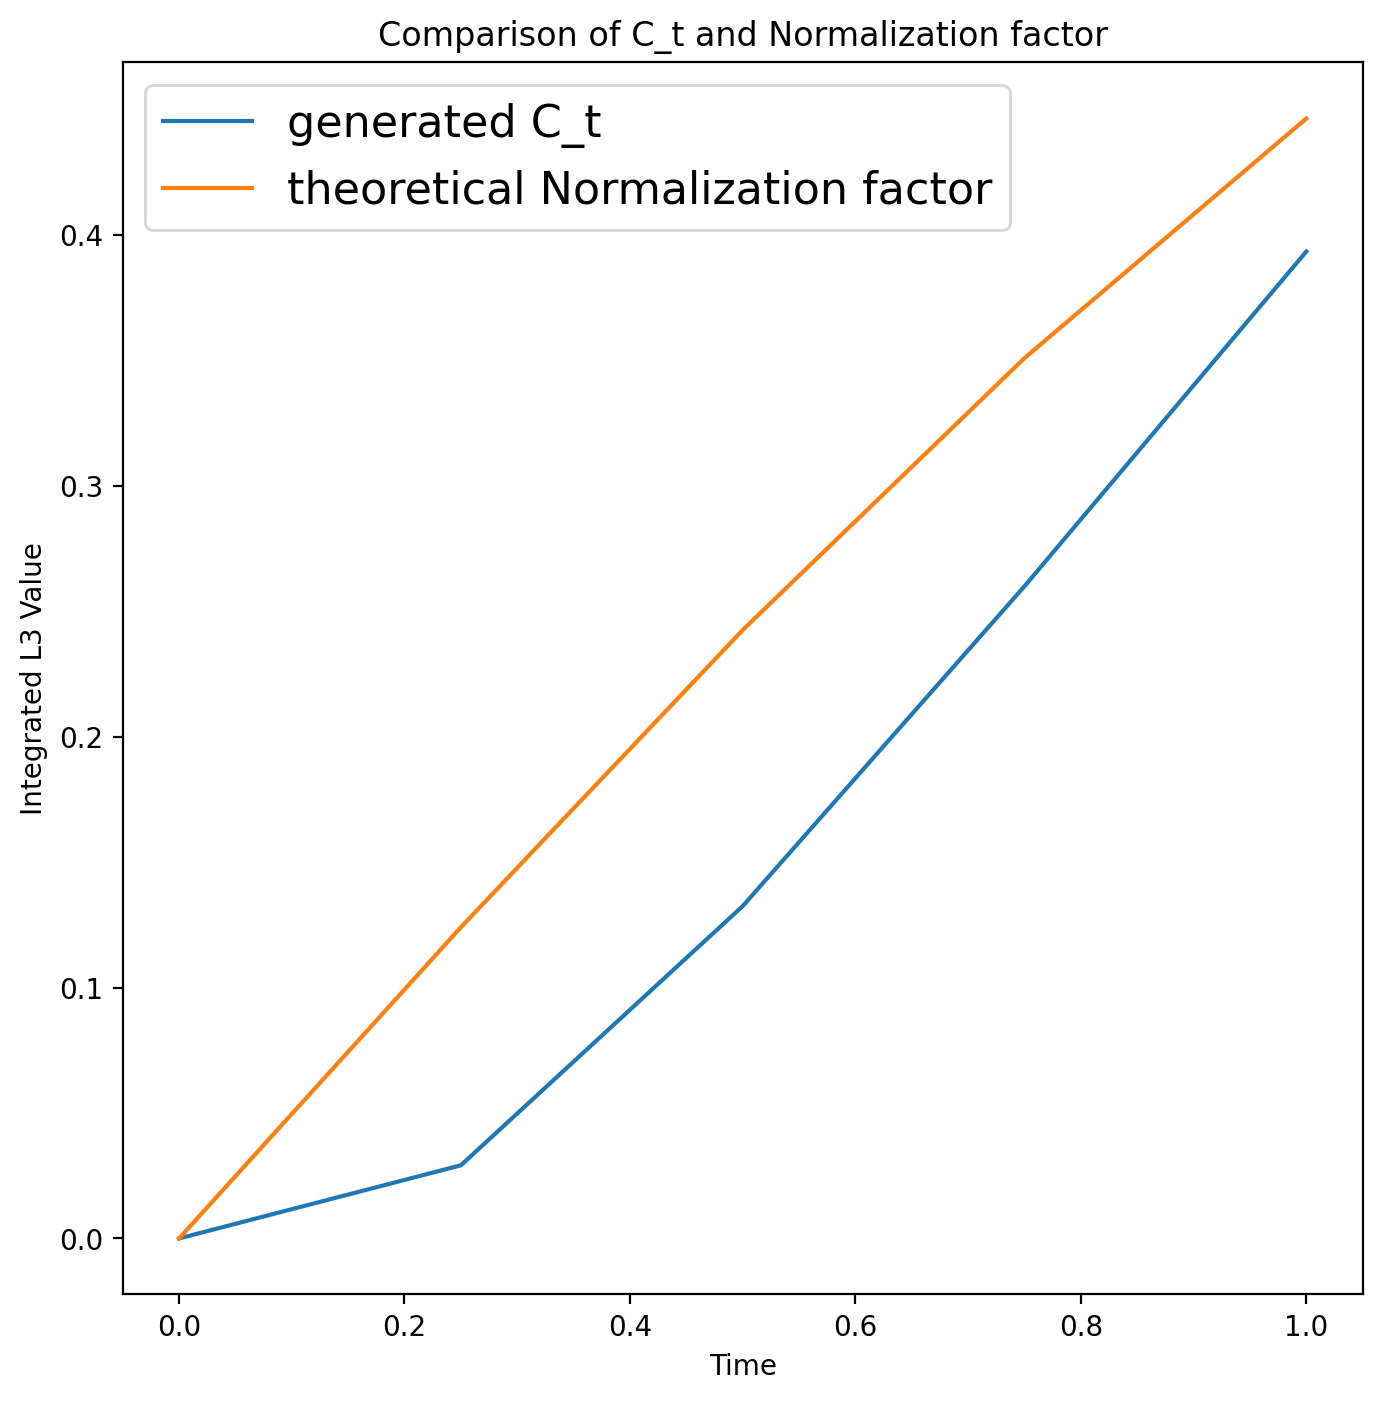

In [7]:
# Integrade the L3 values
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
# Load the data
l3 = np.load("/Users/xuhengyuan/Downloads/PINN/Vonmise/Shallow_PINN_lesslr_l3_data_epoch_19999.npz")
# Extract the data
t_values = l3['t_values']
l3_values = l3['l3_values'][:,0]
print("l3_values",l3_values)
l3_values[0] = 0
print("l3_values",l3_values)


# Integrate Normalzing factor of Vonmise distribution
from scipy.special import i0
import torch
import numpy as np
kappa = torch.linspace(0, 1.0, steps=5, requires_grad=True)
f = torch.log(2 * torch.pi * torch.special.i0(kappa))

# Compute the derivative (gradient) w.r.t. kappa by summing f and calling autograd
gradient = torch.autograd.grad(outputs=f.sum(), inputs=kappa)[0]


# Integrate using cumulative trapezoidal rule
integrated_l3 = np.sqrt(l3_values)
print(integrated_l3)
# Plot the integrated L3 values
plt.figure(figsize=(8, 8),dpi = 200)
plt.plot(t_values, integrated_l3, label = 'generated C_t')
plt.plot(t_values,gradient.numpy(), label = 'theoretical Normalization factor')
plt.xlabel('Time')
plt.legend(fontsize=16)
plt.ylabel('Integrated L3 Value')
plt.title('Comparison of C_t and Normalization factor')
plt.savefig('pinn_Vonmise_C_t.png')

## Save the trained model

In [ ]:
torch.save(Velocity, 'PINN_Vonmise_Velocity.pth')
torch.save(Time_residual, 'PINN_VonmiseP_Time_residual.pth')

## Check the periodic boundary condition of trained model

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set device and t value
device = torch.device('cuda')
t_val = 0.5
pi = np.pi
n_samples = 50  # number of points along the boundary

# ============================
# Check periodicity in x-direction
# ============================
# For each y in [-pi, pi], compare vector_field at x = -pi and x = pi.
y_vals = np.linspace(-pi, pi, n_samples)

# Create tensors for boundary evaluation at x = -pi and x = pi.
x_left = torch.full((n_samples, 1), -pi, dtype=torch.float32, device=device)
x_right = torch.full((n_samples, 1), pi, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y_vals, dtype=torch.float32, device=device).unsqueeze(1)
t_tensor = torch.full((n_samples, 1), t_val, dtype=torch.float32, device=device)

# Evaluate the model on the left and right boundaries.
trained_model.eval()
with torch.no_grad():
    vector_left = trained_model(x_left, y_tensor, t_tensor)
    vector_right = trained_model(x_right, y_tensor, t_tensor)

# Move to CPU and convert to NumPy arrays.
vector_left = vector_left.cpu().numpy()
vector_right = vector_right.cpu().numpy()

# Compute the norm of the difference for each y coordinate.
error_x = np.linalg.norm(vector_left - vector_right, axis=1)

# ============================
# Check periodicity in y-direction
# ============================
# For each x in [-pi, pi], compare vector_field at y = -pi and y = pi.
x_vals = np.linspace(-pi, pi, n_samples)
x_tensor = torch.tensor(x_vals, dtype=torch.float32, device=device).unsqueeze(1)
y_bottom = torch.full((n_samples, 1), -pi, dtype=torch.float32, device=device)
y_top = torch.full((n_samples, 1), pi, dtype=torch.float32, device=device)
t_tensor = torch.full((n_samples, 1), t_val, dtype=torch.float32, device=device)

with torch.no_grad():
    vector_bottom = trained_model(x_tensor, y_bottom, t_tensor)
    vector_top = trained_model(x_tensor, y_top, t_tensor)

vector_bottom = vector_bottom.cpu().numpy()
vector_top = vector_top.cpu().numpy()

# Compute the norm of the difference for each x coordinate.
error_y = np.linalg.norm(vector_bottom - vector_top, axis=1)

# ============================
# Visualization of the periodicity check results
# ============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the error along the x-boundaries as a function of y.
axes[0].plot(y_vals, error_x, 'o-', color='red')
axes[0].set_title('Error between $x=-\pi$ and $x=\pi$')
axes[0].set_xlabel('y coordinate')
axes[0].set_ylabel('Norm difference')
axes[0].grid(True, alpha=0.3)

# Plot the error along the y-boundaries as a function of x.
axes[1].plot(x_vals, error_y, 'o-', color='blue')
axes[1].set_title('Error between $y=-\pi$ and $y=\pi$')
axes[1].set_xlabel('x coordinate')
axes[1].set_ylabel('Norm difference')
axes[1].grid(True, alpha=0.3)

fig.suptitle(f'Periodic Boundary Condition Check at $t={t_val}$', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## call the saved model

In [ ]:
model = torch.load("PINN_Vonmise.pth")
model

## Define the integral function

In [13]:
def solve_ivp_torch(fun: nn.Module, t_span, y0, method='RK45', rtol=1e-3, atol=1e-6):
    """
    A batch-friendly ODE solver using SciPy's solve_ivp internally.
    NOTE: Results are not differentiable through PyTorch autograd.
    """
    B, ND = y0.shape
    device = y0.device

    def fun_wrapper(t, y):
        # 1) Convert incoming y (numpy array) to a PyTorch tensor
        y_torch = torch.from_numpy(y).float().to('cpu').reshape(-1, ND)

        # 2) Convert scalar t to a tensor of shape (B, 1)
        t_torch = torch.ones_like(y_torch[:, :1], device='cpu') * t

        # 3) Evaluate the user-specified function (the ODE’s right-hand side)
        vt = fun(t_torch,y_torch)

        # 4) Convert the result back to numpy, flatten
        return vt.detach().cpu().numpy().reshape(-1)

    # Flatten initial y0 to shape (B*ND,)
    import numpy as np
    from scipy.integrate import solve_ivp

    y0_np = y0.detach().cpu().numpy().reshape(-1)

    sol = solve_ivp(
        fun_wrapper,
        t_span,
        y0_np,
        method=method,
        rtol=rtol,
        atol=atol
    )

    # Return the final solution at t_span[-1], shape (B, ND)
    final_y = sol.y[:, -1]
    final_y_torch = torch.from_numpy(final_y).float().to(device).reshape(B, ND)
    return final_y_torch

torch.Size([100000, 2])
x range: -3.1415624618530273 3.1415293216705322
y range: -3.141482353210449 3.1415512561798096


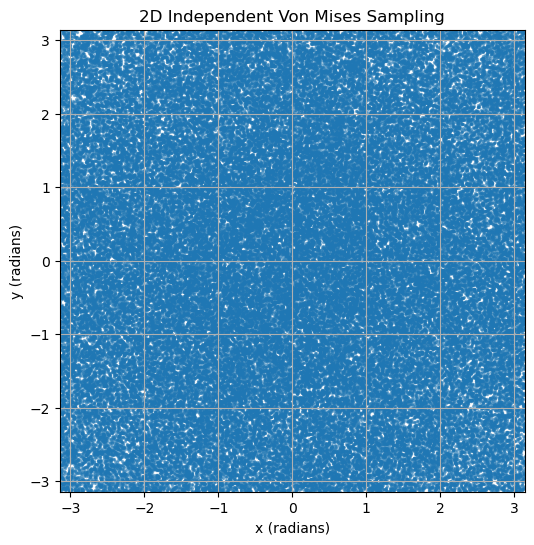

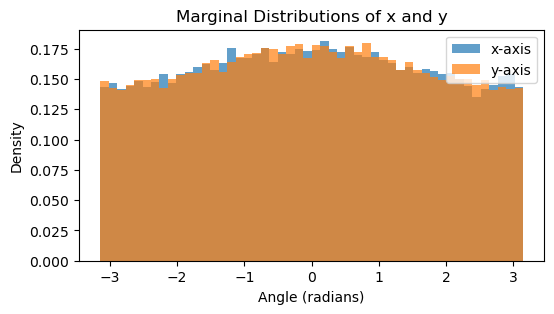

In [5]:
import torch
import math
import matplotlib.pyplot as plt

import torch
import math
import matplotlib.pyplot as plt

# 设定样本数量
num_samples = 100000

# 设定 Von Mises 分布参数
mu_x = 0.0      # x 方向均值角度
mu_y = 0.0      # y 方向均值角度
kappa_x = 0.1   # x 方向集中度
kappa_y = 0.1   # y 方向集中度

# 1. 分别从两个独立的 Von Mises 分布中采样 x 和 y
dist_x = torch.distributions.VonMises(mu_x, kappa_x)
dist_y = torch.distributions.VonMises(mu_y, kappa_y)

samples_x = dist_x.sample((num_samples,))
samples_y = dist_y.sample((num_samples,))

# 2. 确保所有样本严格在 [-π, π] 盒子里（一般不需要，因为 PyTorch 采样默认在 [-π, π]）
samples_x = torch.remainder(samples_x + math.pi, 2 * math.pi) - math.pi
samples_y = torch.remainder(samples_y + math.pi, 2 * math.pi) - math.pi

# 3. 组合成 2D 样本
samples_2d = torch.stack((samples_x, samples_y), dim=1)  # shape: [10000, 2]

# 输出形状检查
print(samples_2d.shape)  # 应该是 [10000, 2]
print("x range:", samples_x.min().item(), samples_x.max().item())
print("y range:", samples_y.min().item(), samples_y.max().item())

# 4. 可视化结果
plt.figure(figsize=(6,6))
plt.scatter(samples_x.numpy(), samples_y.numpy(), s=2, alpha=0.5)
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x (radians)")
plt.ylabel("y (radians)")
plt.title("2D Independent Von Mises Sampling")
plt.grid(True)
plt.show()

# 5. 分别绘制 x 和 y 的直方图
plt.figure(figsize=(6,3))
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Marginal Distributions of x and y")
plt.legend()
plt.show()

torch.Size([100000, 2])
x range: -3.1415441036224365 3.141531229019165
y range: -3.141207218170166 3.1409828662872314


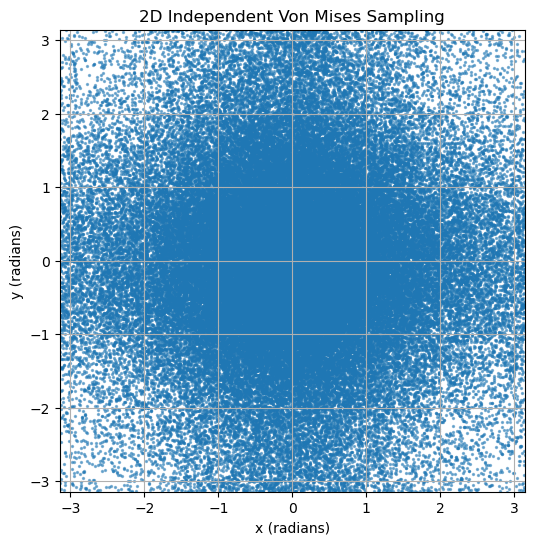

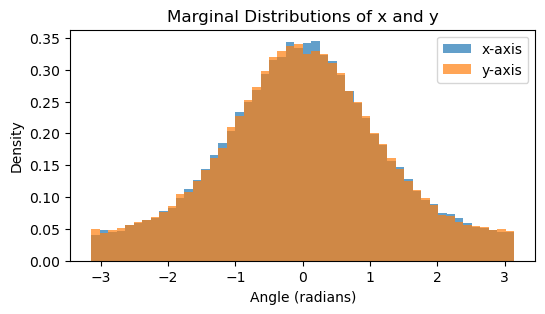

In [6]:
num_samples = 100000

# 设定 Von Mises 分布参数
mu_x = 0.0      # x 方向均值角度
mu_y = 0.0      # y 方向均值角度
kappa_x = 1   # x 方向集中度
kappa_y = 1   # y 方向集中度

# 1. 分别从两个独立的 Von Mises 分布中采样 x 和 y
dist_x = torch.distributions.VonMises(mu_x, kappa_x)
dist_y = torch.distributions.VonMises(mu_y, kappa_y)

samples_x = dist_x.sample((num_samples,))
samples_y = dist_y.sample((num_samples,))

# 2. 确保所有样本严格在 [-π, π] 盒子里（一般不需要，因为 PyTorch 采样默认在 [-π, π]）
samples_x = torch.remainder(samples_x + math.pi, 2 * math.pi) - math.pi
samples_y = torch.remainder(samples_y + math.pi, 2 * math.pi) - math.pi

# 3. 组合成 2D 样本
samples_2d_concentrated = torch.stack((samples_x, samples_y), dim=1)  # shape: [10000, 2]

# 输出形状检查
print(samples_2d_concentrated.shape)  # 应该是 [10000, 2]
print("x range:", samples_x.min().item(), samples_x.max().item())
print("y range:", samples_y.min().item(), samples_y.max().item())

# 4. 可视化结果
plt.figure(figsize=(6,6))
plt.scatter(samples_x.numpy(), samples_y.numpy(), s=2, alpha=0.5)
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x (radians)")
plt.ylabel("y (radians)")
plt.title("2D Independent Von Mises Sampling")
plt.grid(True)
plt.show()

# 5. 分别绘制 x 和 y 的直方图
plt.figure(figsize=(6,3))
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Marginal Distributions of x and y")
plt.legend()
plt.show()

In [1]:
from torchdiffeq import odeint

def ode_dynamics(t, x, model):
    # Expand scalar t to a tensor of shape (batch, 1)
    t_batch = t * torch.ones(x.size(0), 1, device=x.device)
    dxdt = model(t_batch, x)
    return dxdt

def dynamics(t, x):
    return ode_dynamics(t, x, model)

n_pde_points = 100000  # Number of points inside domain
# Generate samples in the latent space
n_particles = 1
n_dimension = 2
device = torch.device('cpu')
samples_prior = torch.rand(n_pde_points, n_particles*n_dimension, device=device,requires_grad=True) * 2*torch.pi - torch.pi  # Range [-10, 10]
# Solve the ODE to get the trajectory
with torch.no_grad():
    # Use the trained model to compute the dynamics
    x_t = odeint(dynamics, samples_prior, torch.tensor(t_values))

NameError: name 'torch' is not defined

In [14]:
t_span = (0, 1.0)
final_y = solve_ivp_torch(model, t_span, samples_2d)
print(final_y.shape)

torch.Size([100000, 2])


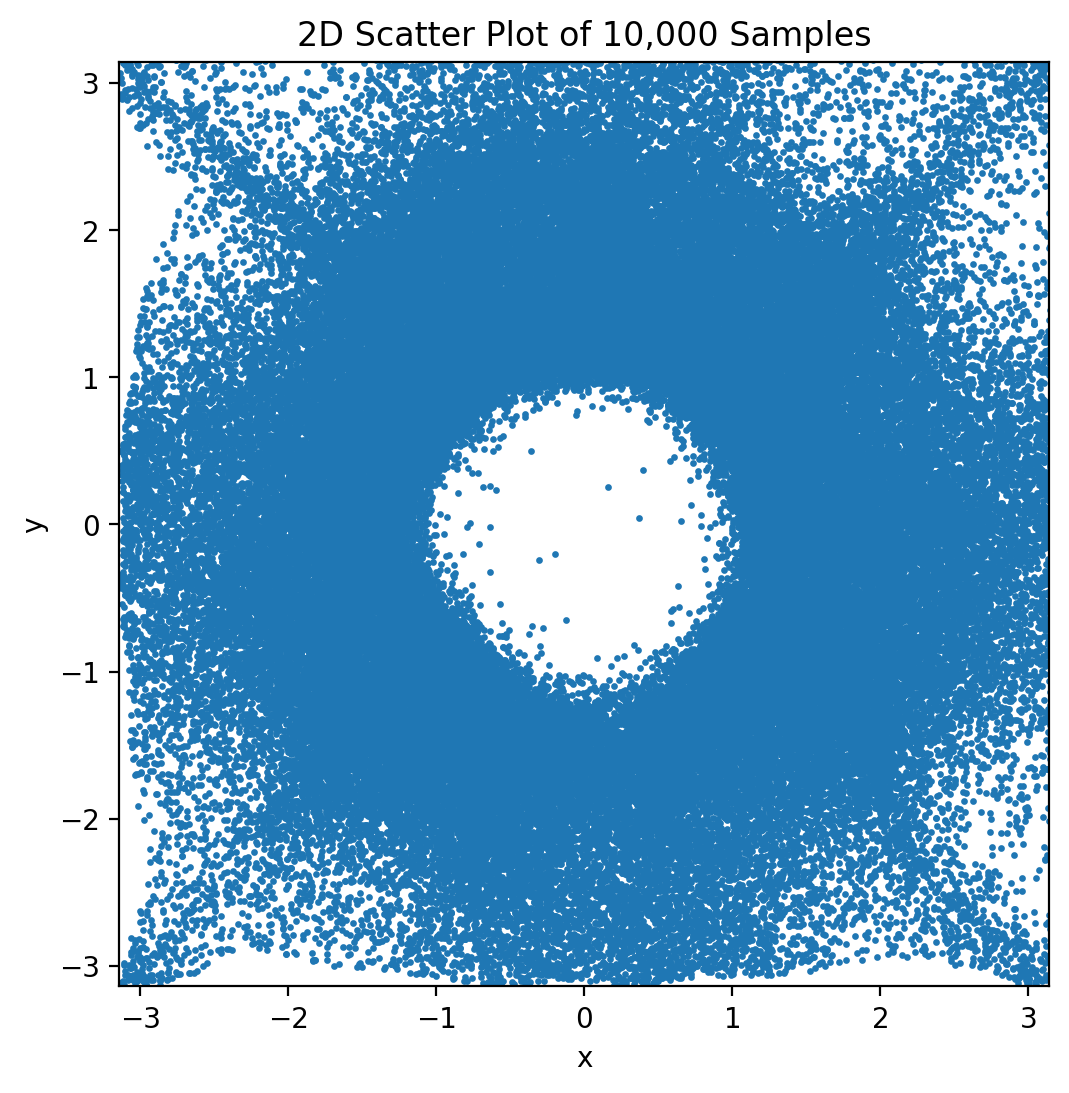

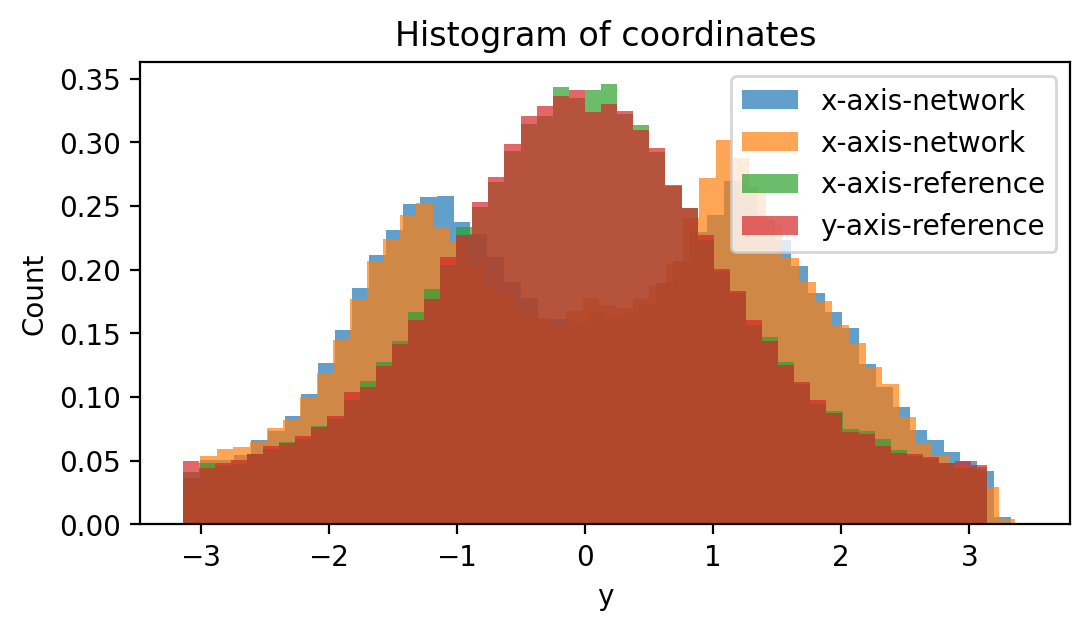

In [20]:
samples_np = final_y.cpu().detach().numpy()

x_vals = samples_np[:, 0]
y_vals = samples_np[:, 1]

# 1) Scatter plot of (x, y)
plt.figure(figsize=(6,6),dpi = 200)
plt.scatter(x_vals, y_vals, s=2)  # s=2 => smaller marker size
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Scatter Plot of 10,000 Samples")
plt.savefig('pinn_Vonmise_2D_scatter.png')  

# 2) Histogram of x
plt.figure(figsize=(6,3),dpi = 200)
plt.hist(x_vals, bins=50, alpha=0.7, density=True, label="x-axis-network")
plt.hist(y_vals, bins=50, alpha=0.7, density=True, label="x-axis-network")
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis-reference")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis-reference")
plt.xlabel("y")
plt.ylabel("Count")
plt.title("Histogram of coordinates")
plt.legend()
plt.savefig('pinn_Vonmise_2D_histogram.png')

In [ ]:
kappa = torch.linspace(0.1, 1.0, steps=100, requires_grad=True)

Time_residual.eval()
with torch.no_grad():  # No need for gradients here
    c_test = Time_residual(kappa.view(100,1).to('cuda'))
c_test

In [ ]:
# Define the function ln(2 * pi * I0(kappa))
f = torch.log(2 * torch.pi * torch.special.i0(kappa))

# Compute the derivative (gradient) w.r.t. kappa by summing f and calling autograd
gradient = torch.autograd.grad(outputs=f.sum(), inputs=kappa)[0]
gradient

In [ ]:
plt.plot(np.linspace(0.1, 1.0,100),gradient.numpy(), label = 'theoretical Normalization factor')
plt.plot(np.linspace(0.1, 1.0,100),c_test.cpu().numpy(), label = 'Network generated')
plt.legend()
plt.show()

In [ ]:
from scipy.special import ivp

# Compute the derivative of the modified Bessel function of the first kind of order 0
dI0_dkappa = ivp(0, kappa.detach()).numpy()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(kappa.detach().numpy(), dI0_dkappa, label=r"$\frac{d}{d\kappa}I_0(\kappa)$", color="orange")
plt.xlabel(r'$\kappa$')
plt.ylabel(r"$\frac{d}{d\kappa}I_0(\kappa)$")
plt.title('Derivative of Modified Bessel Function of the First Kind (Order 0)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()